# Code for AMAS project 1
### *By Niels August Davidsen*

In [106]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

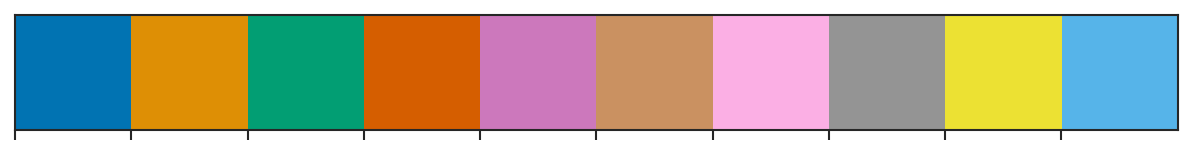

In [107]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
colors = sns.color_palette('colorblind', 10, desat = 1)
#colors = colors[::-1]
#colors.pop(2)
sns.set_palette(colors)
sns.palplot(colors)

# plt.rcParams['axes.grid'] = True
# plt.rcParams['axes.grid.axis'] = 'y'
# plt.rcParams['axes.grid.which'] = 'major'
# plt.rcParams['grid.linestyle'] = '--'
# plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150
# plt.style.use('seaborn-v0_8')

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [108]:
url_2014 = 'https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2025/data/2014KenPomeroy.html'
url_2009 = 'https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2025/data/2009KenPomeroy.html'

In [109]:

# Send a GET request to the webpage
response = requests.get(url_2014)
response.raise_for_status()  # Ensure the request was successful

# Parse the webpage content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table using soup (BS4) - Table id is found by inspecting the HTML file of the webpage
table = soup.find('table', {'id': 'ratings-table'})

# Extract table headers
headers = [th.get_text() for th in table.find('thead').find_all('th')]
headers = list(filter(lambda x: x != '', headers))
headers = headers[2:]


for j in range(4):
    if j == 0:
        headers[-(j + 1)] = headers[-(j + 1)] + '_NCOS'
    else:
        headers[-(j + 1)] = headers[-(j + 1)] + '_SoS'


# Finding strings with ONLY integers of length 1, 2 or 3
pattern = re.compile(r'^\d{1,3}$')
reg_city = re.compile(r'\d{1,2}$')

# Extract table rows
rows = []
for row_number,row in enumerate(table.find('tbody').find_all('tr')):
    cells = row.find_all(['th', 'td'])
    cells_text = [cell.get_text() for cell in cells]
    
    if cells_text[0] == '' or cells_text[0] == ' ' or re.search(r'\d$', cells_text[0]) is None:
        continue
    
    # Remove elements in cells_text that concists ONLY of integers of length 1, 2 or 3
    for i, element in enumerate(cells_text):

        if pattern.match(element) and i > 1:
            cells_text.pop(i)

    reg_search = reg_city.search(cells_text[1])
    if reg_search is not None:
        cells_text[1] = cells_text[1][:- ( len(reg_search.group(0) ) + 1 )]

    # Creating an fail-safe for the case where the length of cells_text does not match the length of headers
    if len(cells_text) != len(headers):
        print(len(cells_text), len(headers))
        print(f'Error: Length of cells_text does not match length of headers in row {row_number}')
    
    rows.append(cells_text)

df_2014 = pd.DataFrame(rows, columns=headers)                                # Create a DataFrame from the rows
df_2014.to_csv('kenpom_2014_ratings.csv', index=False)                       # Save the DataFrame to a CSV file

In [110]:
# Read df using pandas html reader
df_2014_pd = pd.read_html(url_2014, header=17)[0]

# Remove numbers from the team names
df_2014_pd['Team'] = df_2014_pd['Team'].str.replace(r'\d+', '')
df_2014_pd['Team'] = df_2014_pd['Team'].str.strip()

#display(df_2014_pd)                                                             # Display the DataFrame

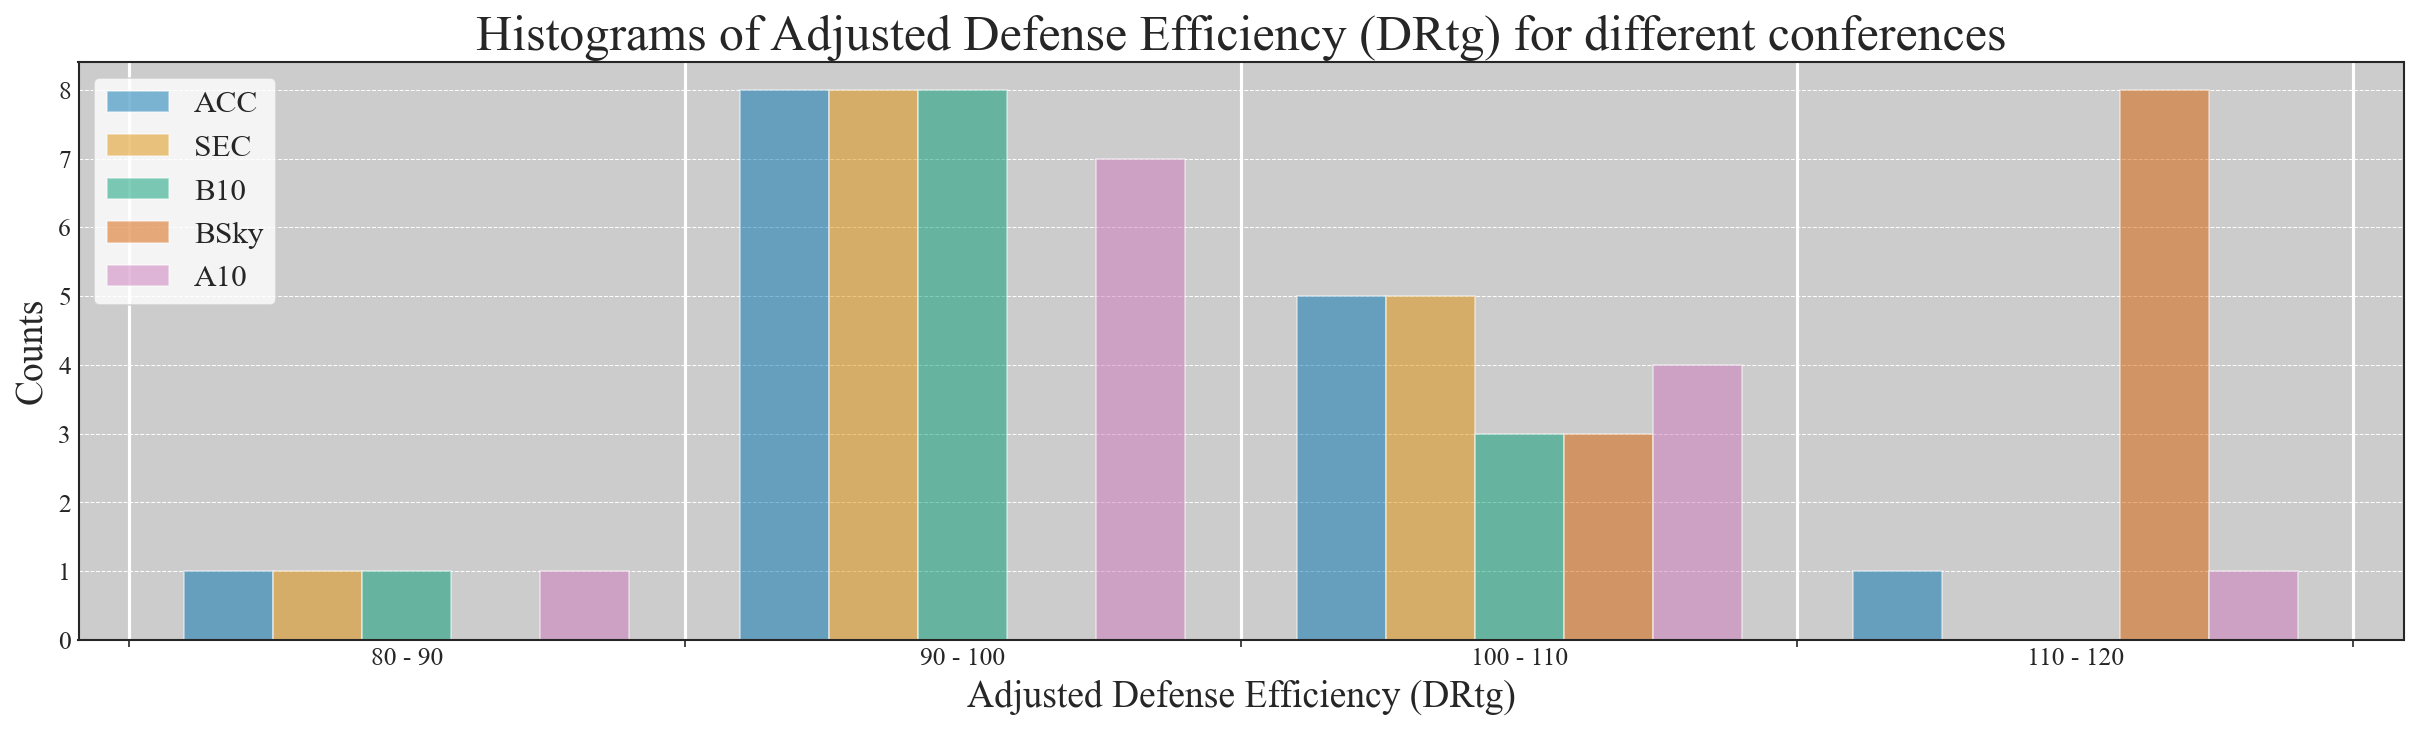

In [111]:
# Grouping the data into conferences (ACC, SEC, B10, BSky and A10)

conf_names = ['ACC', 'SEC', 'B10', 'BSky', 'A10']
fig_conf, ax_conf = plt.subplots(1, 1, figsize=(20, 5), dpi = 150)
hist_range = [80, 120]
bin_arr = np.arange(80, 130, 10)
bin_centers = bin_arr[:-1] + np.diff(bin_arr) / 2

hist_data = []

for i, conf in enumerate(conf_names):
    conf_teams = df_2014[df_2014['Conf'] == conf]
    hist_data.append(conf_teams['DRtg'].astype(float))

ax_conf.hist(hist_data, range=hist_range, bins=bin_arr, alpha=0.5, label=conf_names, color = colors[:len(conf_names)])
ax_conf.set_title('Histograms of Adjusted Defense Efficiency (DRtg) for different conferences', fontsize=24)
ax_conf.set_xlabel('Adjusted Defense Efficiency (DRtg)', fontsize=18)
ax_conf.set_ylabel('Counts', fontsize=18)

ax_conf.grid(visible=True, which='major', axis='y', color = 'white', linestyle='--', linewidth=0.5)  # Grid on bin edges


explanatory_labels = [f"{bin_arr[i]} - {bin_arr[i+1]}" for i in range(len(bin_arr) - 1)]
ax_conf.set_xticks(bin_centers, explanatory_labels)
ax_conf.tick_params(length=0)

# Set grid at bin edges
ax_conf.set_xticks(bin_arr, minor=True)  # Set grid at bin edges
ax_conf.grid(visible=True, which='minor', axis='x', color='white', linestyle='-', linewidth=1.5)  # Grid on bin edges
ax_conf.set_facecolor('0.8')

ax_conf.legend(loc='upper left', fontsize=15)

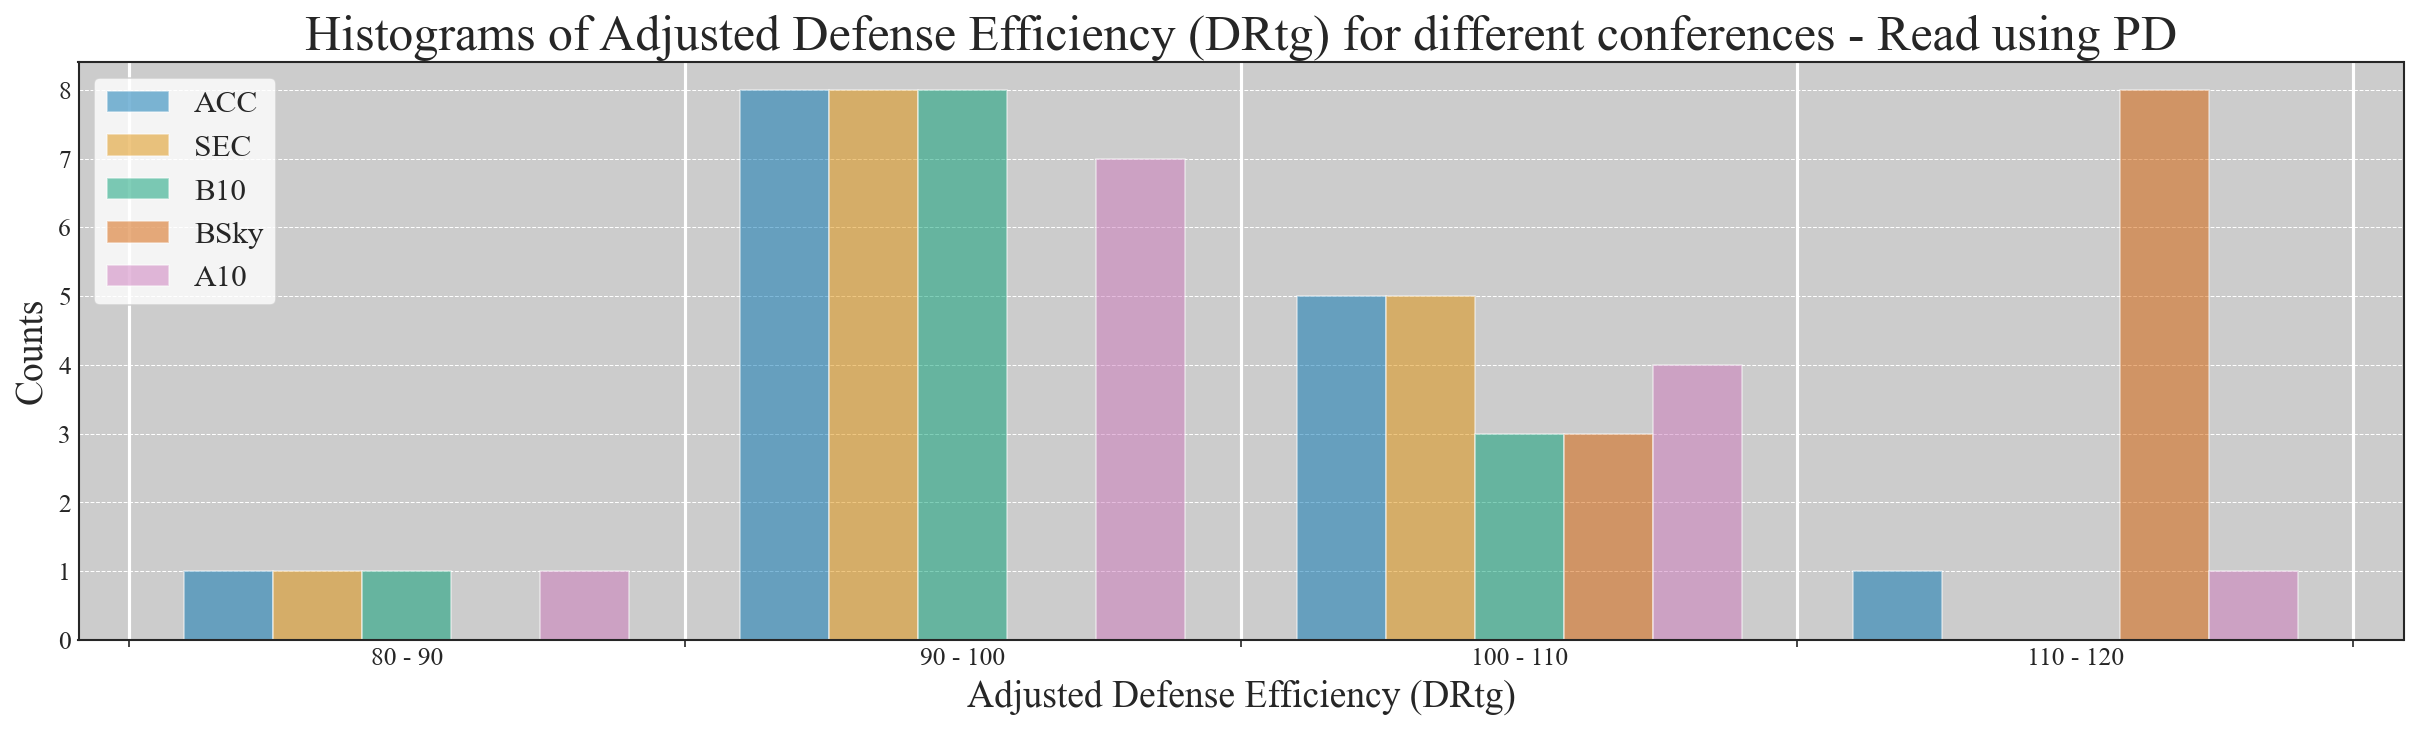

In [112]:
# Same plot for the 2014 data read by pandas
fig_conf_pd, ax_conf_pd = plt.subplots(1, 1, figsize=(20, 5), dpi = 150)
hist_range = [80, 120]
bin_arr = np.arange(80, 130, 10)
bin_centers = bin_arr[:-1] + np.diff(bin_arr) / 2

hist_data_pd = []
for i, conf in enumerate(conf_names):
    conf_teams = df_2014_pd[df_2014_pd['Conf'] == conf]
    hist_data_pd.append(conf_teams['DRtg'].astype(float))

ax_conf_pd.hist(hist_data_pd, range=hist_range, bins=bin_arr, alpha=0.5, label=conf_names, color = colors[:len(conf_names)])
ax_conf_pd.set_title('Histograms of Adjusted Defense Efficiency (DRtg) for different conferences - Read using PD', fontsize=24)
ax_conf_pd.set_xlabel('Adjusted Defense Efficiency (DRtg)', fontsize=18)
ax_conf_pd.set_ylabel('Counts', fontsize=18)

ax_conf_pd.grid(visible=True, which='major', axis='y', color = 'white', linestyle='--', linewidth=0.5)  # Grid on bin edges
explanatory_labels = [f"{bin_arr[i]} - {bin_arr[i+1]}" for i in range(len(bin_arr) - 1)]
ax_conf_pd.set_xticks(bin_centers, explanatory_labels)
ax_conf_pd.tick_params(length=0)

# Set grid at bin edges
ax_conf_pd.set_xticks(bin_arr, minor=True)  # Set grid at bin edges
ax_conf_pd.grid(visible=True, which='minor', axis='x', color='white', linestyle='-', linewidth=1.5)  # Grid on bin edges
ax_conf_pd.set_facecolor('0.8')

ax_conf_pd.legend(loc='upper left', fontsize=15)


_____

In [113]:
# Reading in data 2009

response = requests.get(url_2009)
response.raise_for_status()  # Ensure the request was successful

# Go through webpage content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table using soup (BS4) - Table id is found by inspecting the HTML file of the webpage
table = soup.find('table', {'id': 'ratings-table'})

# Extract table headers
headers = [th.get_text() for th in table.find('thead').find_all('th')]
headers = list(filter(lambda x: x != '', headers))
headers = headers[2:]
for j in range(4):
    if j == 0:
        headers[-(j + 1)] = headers[-(j + 1)] + '_NCOS'
    else:
        headers[-(j + 1)] = headers[-(j + 1)] + '_SoS'

# Extract table rows
rows = []

for row_number,row in enumerate(table.find('tbody').find_all('tr')):
    cells = row.find_all(['th', 'td'])                                # th and td are the table headers and data cells, respectively
    cells_text = [cell.get_text() for cell in cells]

    if cells_text[0] == '' or cells_text[0] == ' ' or re.search(r'\d', cells_text[0]) == None:
        continue
    
    # Remove elements in cells_text that concists ONLY of integers of length 1, 2 or 3
    for i, element in enumerate(cells_text):

        if pattern.match(element) and i > 1:
            cells_text.pop(i)

    reg_search = reg_city.search(cells_text[1])
    if reg_search is not None:
        cells_text[1] = cells_text[1][:- ( len(reg_search.group(0) ) + 1 )]

    # Creating an fail-safe for the case where the length of cells_text does not match the length of headers
    if len(cells_text) != len(headers):
        print(len(cells_text), len(headers))
        print(f'Error: Length of cells_text does not match length of headers in row {row_number}')
    
    rows.append(cells_text)

df_2009 = pd.DataFrame(rows, columns=headers)                                # Create a DataFrame from the rows
df_2009.to_csv('kenpom_2009_ratings.csv', index=False)                       # Save the DataFrame to a CSV file

for i, value in enumerate(df_2009['ORtg']):
    if re.search(r'\d', value) == None:
        print(i, value)


In [114]:
# Read in the data using pandas html reader
df_2009_pd = pd.read_html('2009_data.htm', header=17)[0]

# Remove all numbers in the team names
df_2009_pd['Team'] = df_2009_pd['Team'].str.replace('\d+', '')
df_2009_pd['Team'] = df_2009_pd['Team'].str.strip()

# Display the DataFrame
# display(df_2009_pd)

Team Xavier in conference A10 is not in the 2014 data
Team Temple in conference A10 is not in the 2014 data
Team Charlotte in conference A10 is not in the 2014 data


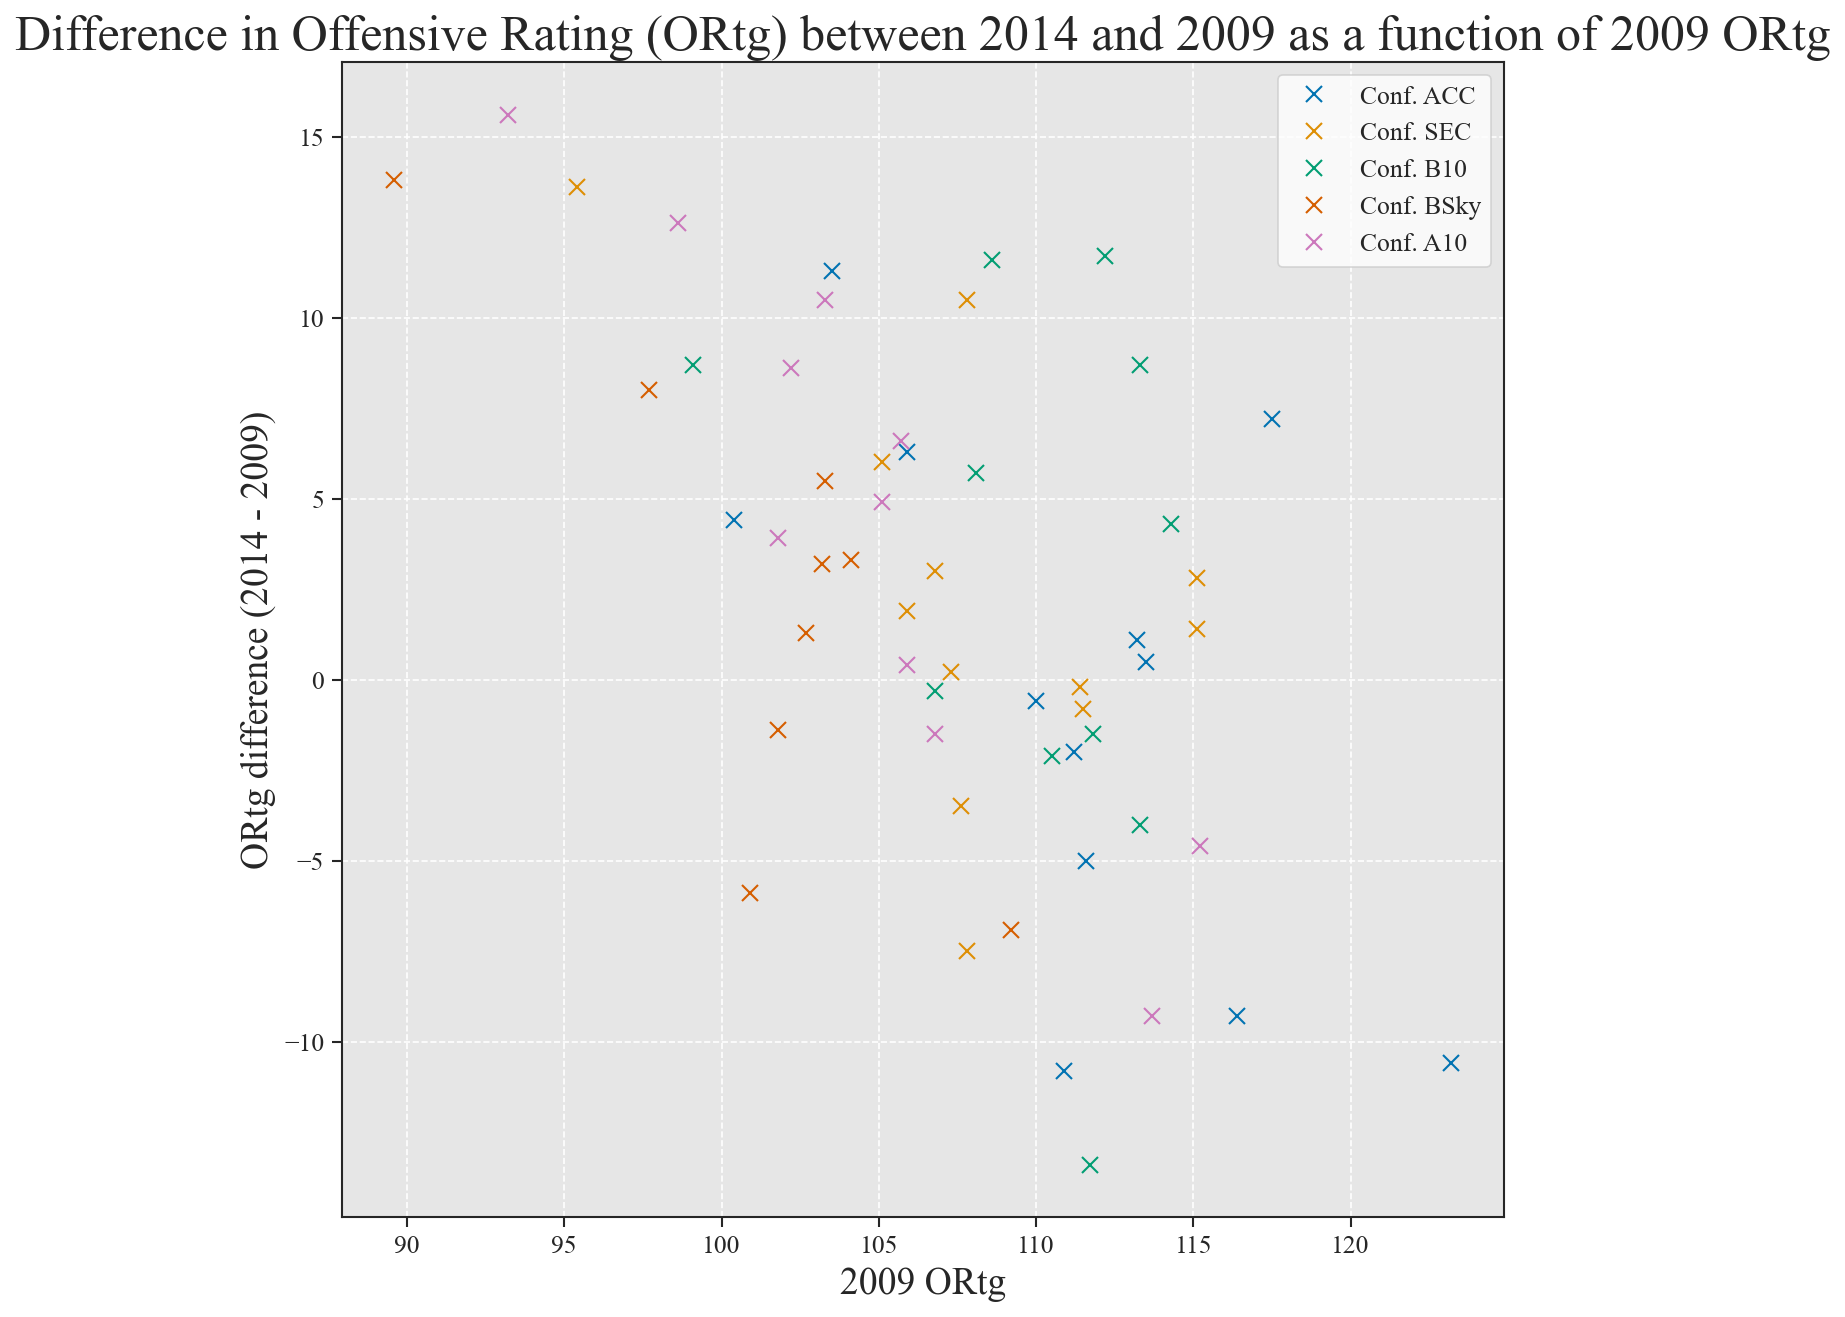

In [115]:
# Grouping the data into conferences (ACC, SEC, B10, BSky and A10)

conf_names = ['ACC', 'SEC', 'B10', 'BSky', 'A10']

fig_diff, ax_diff = plt.subplots(1, 1, figsize=(10, 10), dpi = 150)

for i, conf in enumerate(conf_names):

    ORtg_diff = []
    ORtg = []
    conf_teams_2009 = df_2009[df_2009['Conf'] == conf].copy()
    conf_teams_2009['ORtg'] = conf_teams_2009['ORtg'].astype(float)

    conf_teams_2014 = df_2014[df_2014['Conf'] == conf].copy()
    conf_teams_2014['ORtg'] = conf_teams_2014['ORtg'].astype(float)

    for team in conf_teams_2009['Team']:
        if team not in conf_teams_2014['Team'].values:
            print(f'Team {team} in conference {conf} is not in the 2014 data')
        else: 
            diff = conf_teams_2014[conf_teams_2014['Team'] == team]['ORtg'].values - conf_teams_2009[conf_teams_2009['Team'] == team]['ORtg'].values
            ORtg_diff.append(diff[0])
            ORtg.append(conf_teams_2009[conf_teams_2009['Team'] == team]['ORtg'].values[0])


    ax_diff.plot(ORtg, ORtg_diff, 'x', markersize=8, label= f'Conf. {conf}', color=colors[i])

    
ax_diff.legend()
ax_diff.set_title('Difference in Offensive Rating (ORtg) between 2014 and 2009 as a function of 2009 ORtg', fontsize=24)
ax_diff.set_xlabel('2009 ORtg', fontsize=18)
ax_diff.set_ylabel('ORtg difference (2014 - 2009)', fontsize=18)
ax_diff.grid(visible=True, which='major', axis='both', color='white', linestyle='--', linewidth=0.8)
ax_diff.set_facecolor('0.9')
            
    

In [116]:
# Finding the median and mean of the ORtg difference for each conference using pandas dataframe
conf_names = ['ACC', 'SEC', 'B10', 'BSky', 'A10']

conf_diff = pd.DataFrame(columns=['Conference', '# teams', 'Median ORtg diff', 'Mean ORtg diff'])

for conf in conf_names:
    conf_teams_2009 = df_2009[df_2009['Conf'] == conf].copy()
    conf_teams_2009['ORtg'] = conf_teams_2009['ORtg'].astype(float)

    conf_teams_2014 = df_2014[df_2014['Conf'] == conf].copy()
    conf_teams_2014['ORtg'] = conf_teams_2014['ORtg'].astype(float)

    ORtg_diff = []

    for team in conf_teams_2009['Team']:
        if team not in conf_teams_2014['Team'].values:
            print(f'Team {team} in conference {conf} is not in the 2014 data')
        else:
            diff = conf_teams_2014[conf_teams_2014['Team'] == team]['ORtg'].values - conf_teams_2009[conf_teams_2009['Team'] == team]['ORtg'].values
            ORtg_diff.append(diff[0])

    ORtg_diff = pd.Series(ORtg_diff)

    # Joining together a new dataframe with the columns: Conference, # teams, median diff, mean diff
    new_row = {'Conference': conf, '# teams': len(ORtg_diff), 'Median ORtg diff': ORtg_diff.median(), 'Mean ORtg diff': ORtg_diff.mean()}

    # Checking if the median or mean of the ORtg difference is NaN
    if np.isnan(new_row['Median ORtg diff']):
        print(conf_teams_2009['ORtg'], conf_teams_2014['ORtg'])
    else:
        conf_diff = conf_diff._append(new_row, ignore_index=True)


# Grouping data of conferences not in conf names
conf = 'Other confernces'
conf_teams_2009_other = df_2009[~df_2009['Conf'].isin(conf_names)].copy()
conf_teams_2009_other['ORtg'] = conf_teams_2009_other['ORtg'].astype(float)

conf_teams_2014_other = df_2014[~df_2014['Conf'].isin(conf_names)].copy()
conf_teams_2014_other['ORtg'] = conf_teams_2014_other['ORtg'].astype(float)

ORtg_diff = []

for team in conf_teams_2009_other['Team']:
    if team not in conf_teams_2014_other['Team'].values:
        print(f'Team {team} in conference {conf} is not in the 2014 data')
    else:
        diff = conf_teams_2014_other[conf_teams_2014_other['Team'] == team]['ORtg'].values - conf_teams_2009_other[conf_teams_2009_other['Team'] == team]['ORtg'].values
        ORtg_diff.append(diff[0])

ORtg_diff = pd.Series(ORtg_diff)

new_row = {'Conference': conf, '# teams': len(ORtg_diff), 'Median ORtg diff': ORtg_diff.median(), 'Mean ORtg diff': ORtg_diff.mean()}
conf_diff = conf_diff._append(new_row, ignore_index=True)




display(conf_diff)


# Converting the DataFrame to a LaTeX table
print(conf_diff.to_latex(index=False))


    

Team Xavier in conference A10 is not in the 2014 data
Team Temple in conference A10 is not in the 2014 data
Team Charlotte in conference A10 is not in the 2014 data
Team Pittsburgh in conference Other confernces is not in the 2014 data
Team Missouri in conference Other confernces is not in the 2014 data
Team Syracuse in conference Other confernces is not in the 2014 data
Team Notre Dame in conference Other confernces is not in the 2014 data
Team Texas A&M in conference Other confernces is not in the 2014 data
Team VCU in conference Other confernces is not in the 2014 data
Team Nebraska in conference Other confernces is not in the 2014 data
Team George Mason in conference Other confernces is not in the 2014 data
Team Southern Utah in conference Other confernces is not in the 2014 data
Team Centenary in conference Other confernces is not in the 2014 data
Team Winston Salem St. in conference Other confernces is not in the 2014 data


C:\Users\Niels\AppData\Local\Temp\ipykernel_11012\1457388614.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  conf_diff = conf_diff._append(new_row, ignore_index=True)


,Conference,# teams,Median ORtg diff,Mean ORtg diff
0,ACC,12,-0.05,-0.625000
1,SEC,12,1.65,2.283333
2,B10,11,4.30,2.672727
3,BSky,9,3.20,2.322222
4,A10,11,4.90,4.336364
5,Other confernces,275,1.90,2.595273


\begin{tabular}{llrr}
\toprule
Conference & # teams & Median ORtg diff & Mean ORtg diff \\
\midrule
ACC & 12 & -0.050000 & -0.625000 \\
SEC & 12 & 1.650000 & 2.283333 \\
B10 & 11 & 4.300000 & 2.672727 \\
BSky & 9 & 3.200000 & 2.322222 \\
A10 & 11 & 4.900000 & 4.336364 \\
Other confernces & 275 & 1.900000 & 2.595273 \\
\bottomrule
\end{tabular}

